## 09/30/21 - Lupercio, Daniel

We will apply our general Statistical Theory Framework in the case when the output variable `Y` is categorical. In this notebok we will consider 

* Logistic Regression
* Linear Discriminant Analysis (LDA)
* Quadratic Discriminant Analysis (QDA)
* K-nearest neighbor (KNN)

In [1]:
# Load packages we will need
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
# Confusion matrix

def plot_cm(labels, predictions, p=0.5):
    
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total Positive (Actual): ', np.sum(cm[1]))

In [3]:
# ROC
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'violet', 'orange', 'purple']
    
def plot_roc(name, labels, predictions, **kwargs):
    
    #plt.figure(figsize = (6, 6))
    plt.style.use('ggplot')
    
    fp, tp, _ = roc_curve(labels, predictions)

    lbl = name + " AUC: "+str(round(roc_auc_score(1-labels, 1-predictions.ravel()),3))
    plt.plot(100*fp, 100*tp, label=lbl, linewidth=2, **kwargs)
    plt.plot(100*fp, 100*fp,'r--');
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    #plt.xlim([-0.5,20])
    #plt.ylim([80,100.5])
    #plt.grid(True)
    
    #plt.plot(fpr, tpr, label = "ROC score: "+str(round(roc_auc_score(1-y_test, 1-pred_vals[:,1]),3)), color = "violet", lw = 3);

    ax = plt.gca()
    ax.set_aspect('equal')

In [4]:
import os

UP_DIR = "/Users/daniel421/Desktop/STAT_724/ISLR_data/"
csv_file = os.path.join(UP_DIR, "Smarket.csv")
smarket = pd.read_csv(csv_file, header = 0, index_col = 0, squeeze = True)

In [5]:
smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


Let's begin by creating a 0-1 output 

In [6]:
smarket["Direction2"] = smarket.Direction.map({'Up':1,
                                              'Down':0})

In [7]:
smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction2
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up,1
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,1
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,0
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,1
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,1


We now split the data into a training and testing portion. Train:(before 2005), Test:(on or after 2005)

In [8]:
smarket_train = smarket[smarket['Year'] < 2005]
smarket_test = smarket[smarket['Year'] >= 2005]

In [9]:
print('train size: {0} & test size {1}'.format(smarket_train.shape[0], smarket_test.shape[0]))

train size: 998 & test size 252


#### 4.6.1 The Stock Market Data
We will be examining the Smarket data set for this lab. It contains a number of numeric variables plus a variable called Direction which has the two labels "Up" and "Down". 

The Smarket data, which is part of the ISLR library, consists of percentage returns for the S&P 500 stock index **over 1,250 days**, from the beginning of 2001 until the end of 2005. 

For each date, we have recorded the percentage returns for each of the five previous trading days, Lag1 through Lag5. We have also recorded **Volume** (the number of shares traded on the previous day, in billions), **Today** (the percentage return on the date in question) and **Direction** (whether the market was Up or Down on this date).

### Logistic Regression

Select only Lag1 and Lag2 as predictors

In [10]:
X_train = smarket_train[['Lag1','Lag2']]
y_train = smarket_train['Direction2']
X_test = smarket_test[['Lag1','Lag2']]
y_test = smarket_test['Direction2']

Fit the model on the train data

In [14]:
clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y_train)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(solver='newton-cg')
classes:  [0 1]
coefficients:  [[-0.05547007 -0.04436492]]
intercept : [0.0322169]


Test the accuracy of the model on the test data - "look at the refresher" on metrics at the end

In [15]:
pred = clf.predict(X_test)
pred, y_test.T

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1]),
 999     0
 1000    0
 1001    0
 1002    1
 1003    0
        ..
 1246    1
 1247    0
 1248    1
 1249    0
 1250    0
 Name: Direction2, Length

In [16]:
# Find the accuracy of the predictions against the true classes
print("accuracy: %0.3f" % accuracy_score(y_test, pred))

accuracy: 0.560


In [17]:
# Show the confusion matrix
#print(confusion_matrix(y_test, pred))
cm_df = pd.DataFrame(confusion_matrix(y_test, pred).T, index=clf.classes_,columns=clf.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print('\nConfusion table:\n', cm_df)


Confusion table:
 True        0    1
Predicted         
0          35   35
1          76  106


In [18]:
# Additional statistics
print('\n',classification_report(y_test, pred))


               precision    recall  f1-score   support

           0       0.50      0.32      0.39       111
           1       0.58      0.75      0.66       141

    accuracy                           0.56       252
   macro avg       0.54      0.53      0.52       252
weighted avg       0.55      0.56      0.54       252



True Negatives:  35
False Positives:  76
False Negatives:  35
True Positives:  106
Total Positive (Actual):  141


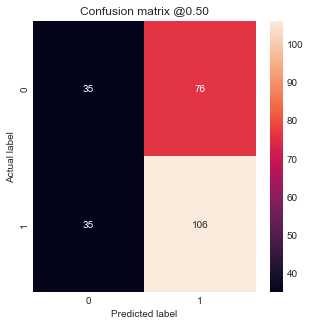

In [19]:
plot_cm(y_test, pred)

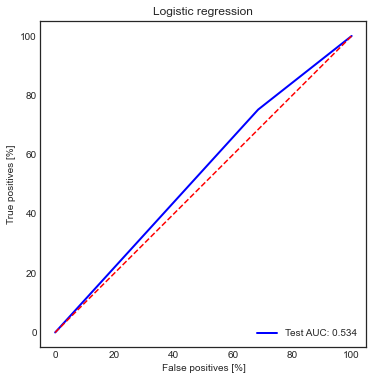

In [20]:
plt.figure(figsize = (6, 6))

plt.title('Logistic regression')
#plot_roc("Train", train_labels, train_predictions_m1, color=colors[2])
plot_roc("Test", y_test, pred, color=colors[2]) #, linestyle='--')
plt.legend(loc='lower right')

### Linear Discriminant Analysis

Use the same two predictors (Lag1 and Lag2) to forecast up/down market movement but fit an LDA model

In [22]:
lda = LinearDiscriminantAnalysis()
pred = lda.fit(X_train, y_train).predict(X_test)

print(lda.priors_)
print(lda.means_)

[0.49198397 0.50801603]
[[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]


In [25]:
# Find the accuracy of the predictions against the true classes
print("accuracy: %0.3f" % accuracy_score(y_test, pred))

# Show the confusion matrix
cm_df = pd.DataFrame(confusion_matrix(y_test, pred).T, index=clf.classes_,columns=clf.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print('\nConfusion table:\n', cm_df)

# Additional statistics
print('\n',classification_report(y_test, pred))

accuracy: 0.560

Confusion table:
 True        0    1
Predicted         
0          35   35
1          76  106

               precision    recall  f1-score   support

           0       0.50      0.32      0.39       111
           1       0.58      0.75      0.66       141

    accuracy                           0.56       252
   macro avg       0.54      0.53      0.52       252
weighted avg       0.55      0.56      0.54       252

